# Projekt uczenie maszynowe - klasyfikacja

## Biblioteki

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import random

In [2]:
weather = pd.read_csv("klasyfikacja/weather_classification_data.csv")
weather.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


Opis i analiza danych przeprowadzone zostaly w projekcie 1

Obróbka danych

In [3]:
categorical_cols = ['Cloud Cover', 'Season', 'Location']
label_encoders = {}

numeric_cols = [
    'Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
    'Atmospheric Pressure', 'UV Index', 'Visibility (km)'
]

for col in categorical_cols:
    le = LabelEncoder()
    weather[col] = le.fit_transform(weather[col])
    label_encoders[col] = le

def remove_outliers_iqr(df, columns):
    cleaned_df = df.copy()
    for col in columns:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        before = cleaned_df.shape[0]
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower) & (cleaned_df[col] <= upper)]
        after = cleaned_df.shape[0]
        print(f"Removed {before - after} outliers from '{col}'")
    return cleaned_df


cleaned_df = remove_outliers_iqr(weather, numeric_cols)

Removed 92 outliers from 'Temperature'
Removed 0 outliers from 'Humidity'
Removed 396 outliers from 'Wind Speed'
Removed 0 outliers from 'Precipitation (%)'
Removed 927 outliers from 'Atmospheric Pressure'
Removed 112 outliers from 'UV Index'
Removed 87 outliers from 'Visibility (km)'


Podział na X i y

In [4]:
X = cleaned_df.drop("Weather Type", axis=1)
y = cleaned_df["Weather Type"]

# Implementacja drzewa decyzyjnego dla klasyfikacji

In [5]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, feature_subset_ratio=1.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.feature_subset_ratio = feature_subset_ratio
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._predict_single(sample, self.tree) for sample in X])

    def _predict_single(self, sample, node):
        while isinstance(node, dict):
            feature, threshold = node['feature'], node['threshold']
            if sample[feature] <= threshold:
                node = node['left']
            else:
                node = node['right']
        return node

    def _gini(self, y):
        m = len(y)
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

    def _best_split(self, X, y, features):
        best_gain = -1
        best_split = None

        for feature in features:
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue

                y_left, y_right = y[left_mask], y[right_mask]
                gain = self._gini(y) - (
                    len(y_left) / len(y) * self._gini(y_left) +
                    len(y_right) / len(y) * self._gini(y_right)
                )

                if gain > best_gain:
                    best_gain = gain
                    best_split = {
                        'feature': feature,
                        'threshold': threshold,
                        'left_mask': left_mask,
                        'right_mask': right_mask
                    }

        return best_split

    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))

        if (self.max_depth is not None and depth >= self.max_depth) or \
           num_samples < self.min_samples_split or \
           num_classes == 1:
            return np.bincount(y).argmax()

        feature_indices = np.random.choice(num_features,
                                           int(self.feature_subset_ratio * num_features),
                                           replace=False)
        split = self._best_split(X, y, feature_indices)
        if split is None:
            return np.bincount(y).argmax()

        left = self._grow_tree(X[split['left_mask']], y[split['left_mask']], depth + 1)
        right = self._grow_tree(X[split['right_mask']], y[split['right_mask']], depth + 1)
        return {'feature': split['feature'], 'threshold': split['threshold'], 'left': left, 'right': right}

# Analiza wyników drzewa decyzyjnego

| Parametr            | Znaczenie i sens testowania                                      |
|---------------------|-----------------------------------------------------------------|
| `max_depth`         | Maksymalna głębokość drzewa, kontroluje złożoność i przeuczenie.|
| `min_samples_split` | Min. liczba próbek do podziału węzła, wpływa na wielkość drzewa.|
| `min_samples_leaf`  | Min. liczba próbek w liściu, zapobiega przeuczeniu.             |
| `feature_subset_ratio` | Udział losowo wybieranych cech przy podziale, poprawia uogólnienie. |

In [6]:
wyniki_df = pd.read_excel('klasyfikacja/wyniki_drzewo_klasyfikacja.xlsx')
wyniki_df.head()

,parametr,wartość,Accuracy_train,Accuracy_test,Precision_train_class_0,Precision_train_class_1,Precision_train_class_2,Precision_train_class_3,Recall_train_class_0,Recall_train_class_1,...,Precision_test_class_2,Precision_test_class_3,Recall_test_class_0,Recall_test_class_1,Recall_test_class_2,Recall_test_class_3,F1_test_class_0,F1_test_class_1,F1_test_class_2,F1_test_class_3
0,max_depth,2.0,0.718925,0.713115,0.487320,0.000000,0.996960,0.863215,0.902666,0.000000,...,0.992537,0.875776,0.932998,0.000000,0.974359,0.938436,0.642075,0.000000,0.983364,0.906024
1,max_depth,4.0,0.960941,0.949094,0.922481,0.961258,0.998261,0.964270,0.956835,0.943202,...,0.996255,0.969072,0.959799,0.925087,0.974359,0.938436,0.926435,0.934859,0.985185,0.953508
2,max_depth,6.0,0.975615,0.970233,0.962900,0.945643,0.998698,0.995654,0.955565,0.980322,...,0.996255,0.988115,0.961474,0.977352,0.974359,0.968386,0.957465,0.961440,0.985185,0.978151
3,max_depth,8.0,0.984247,0.971959,0.969735,0.973859,0.993573,1.000000,0.976301,0.983005,...,0.983425,0.991497,0.971524,0.968641,0.978022,0.970050,0.959471,0.967798,0.980716,0.980656
4,min_samples_split,5.0,0.995576,0.970233,0.991147,0.995522,0.997426,0.998285,0.994922,0.994186,...,0.988889,0.986555,0.966499,0.959930,0.978022,0.976705,0.956882,0.959930,0.983425,0.981605


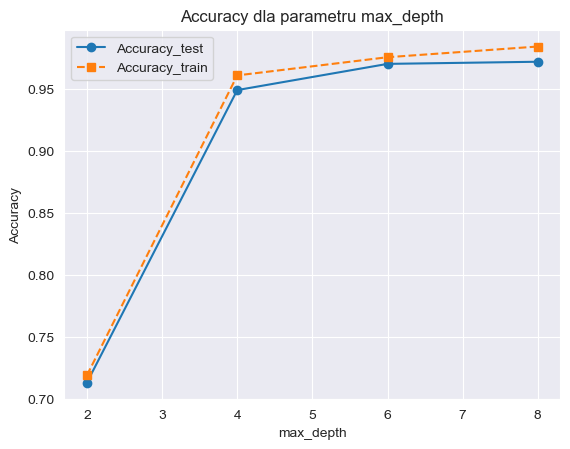

Najlepsza wartość parametru max_depth: 8.0 z Accuracy_test = 0.9719585849870578


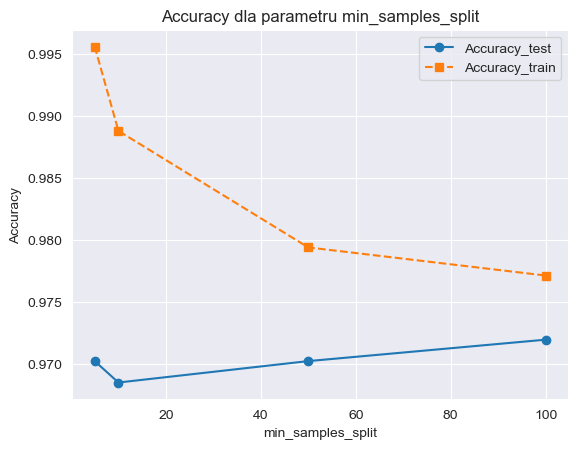

Najlepsza wartość parametru min_samples_split: 100.0 z Accuracy_test = 0.9719585849870578


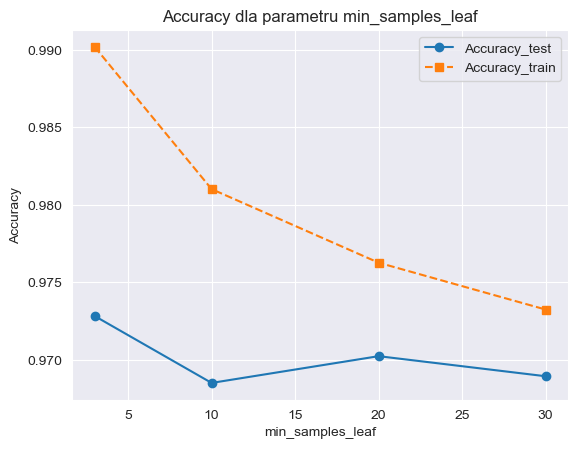

Najlepsza wartość parametru min_samples_leaf: 3.0 z Accuracy_test = 0.9728213977566867


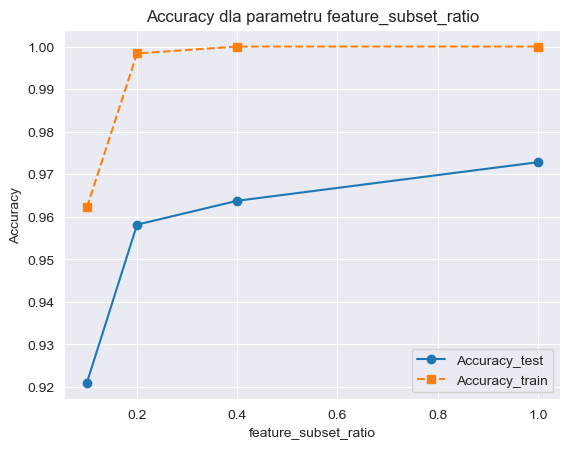

Najlepsza wartość parametru feature_subset_ratio: 1.0 z Accuracy_test = 0.9728213977566867


In [7]:
for param in wyniki_df['parametr'].unique():
    df = wyniki_df[wyniki_df['parametr'] == param]

    plt.figure()
    plt.plot(df['wartość'], df['Accuracy_test'], marker='o', label='Accuracy_test')
    plt.plot(df['wartość'], df['Accuracy_train'], marker='s', linestyle='--', label='Accuracy_train')
    plt.xlabel(param)
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy dla parametru {param}')
    plt.grid(True)
    plt.legend()
    plt.show()

    best_row = df.loc[df['Accuracy_test'].idxmax()]
    print(f"Najlepsza wartość parametru {param}: {best_row['wartość']} z Accuracy_test = {best_row['Accuracy_test']}")



In [8]:
classes = ['Rainy', 'Cloudy', 'Sunny', 'Snowy']

def mean_f1(df):
    cols = [f"F1_test_class_{i}" for i in range(len(classes))]
    return df[cols].mean(axis=1)

wyniki_df['F1_test_mean'] = mean_f1(wyniki_df)


best_values = wyniki_df.loc[wyniki_df.groupby('parametr')['F1_test_mean'].idxmax(), ['parametr', 'wartość', 'F1_test_mean']]
best_values.round(4).reset_index(drop=True)


,parametr,wartość,F1_test_mean
0,feature_subset_ratio,1.0,0.9730
1,max_depth,8.0,0.9722
2,min_samples_leaf,3.0,0.9731
3,min_samples_split,100.0,0.9723


In [9]:
def mean_precision(df):
    cols = [f"Precision_test_class_{i}" for i in range(len(classes))]
    return df[cols].mean(axis=1)

wyniki_df['Precision_test_mean'] = mean_precision(wyniki_df)

best_precision_values = wyniki_df.loc[wyniki_df.groupby('parametr')['Precision_test_mean'].idxmax(), ['parametr', 'wartość', 'Precision_test_mean']]

best_precision_values.round(4).reset_index(drop=True)


,parametr,wartość,Precision_test_mean
0,feature_subset_ratio,1.0,0.9731
1,max_depth,8.0,0.9724
2,min_samples_leaf,3.0,0.9735
3,min_samples_split,100.0,0.9729


In [10]:
def mean_recall(df):
    cols = [f"Recall_test_class_{i}" for i in range(len(classes))]
    return df[cols].mean(axis=1)

wyniki_df['Recall_test_mean'] = mean_recall(wyniki_df)

best_recall_values = wyniki_df.loc[wyniki_df.groupby('parametr')['Recall_test_mean'].idxmax(), ['parametr', 'wartość', 'Recall_test_mean']]

best_recall_values.round(4).reset_index(drop=True)


,parametr,wartość,Recall_test_mean
0,feature_subset_ratio,1.0,0.9729
1,max_depth,8.0,0.9721
2,min_samples_leaf,3.0,0.9728
3,min_samples_split,100.0,0.9720


Analiza wykazała, że model drzewa decyzyjnego najlepiej radzi sobie z klasyfikacją pogody przy
- max_depth=8.0,
- min_samples_split=100.0,
 - min_samples_leaf=3.0
  - feature_subset_ratio=1.0


## Implementacja Regresji Logistycznej dla klasyfikacji

In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler

class LogisticRegression:
    def __init__(self, lr=0.01, n_iter=1000, batch_size=32, lambda_reg=0.0):
        self.lr = lr
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.lambda_reg = lambda_reg
        self.scaler = StandardScaler()

    def _one_hot(self, y, num_classes):
        one_hot = np.zeros((y.size, num_classes))
        one_hot[np.arange(y.size), y] = 1
        return one_hot

    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        X = self.scaler.fit_transform(X)
        n_samples, n_features = X.shape
        n_classes = np.unique(y).size
        y_one_hot = self._one_hot(y, n_classes)

        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros(n_classes)

        for epoch in range(self.n_iter):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y_one_hot[indices]

            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]

                logits = X_batch @ self.weights + self.bias
                probs = self._softmax(logits)

                error = probs - y_batch
                grad_w = (X_batch.T @ error) / X_batch.shape[0] + self.lambda_reg * self.weights
                grad_b = np.sum(error, axis=0) / X_batch.shape[0]

                self.weights -= self.lr * grad_w
                self.bias -= self.lr * grad_b

    def predict(self, X):
        X = self.scaler.transform(X)
        logits = X @ self.weights + self.bias
        return np.argmax(self._softmax(logits), axis=1)


## Analiza wyników Regresji Logistycznej

| Parametr            | Znaczenie i sens testowania                                      |
|---------------------|-----------------------------------------------------------------|
| `lr`         | Learning rate– decyduje o wielkości kroku podczas aktualizacji wag.|
| `n_iter` | Liczba epok– ile razy cały zbiór treningowy jest używany do aktualizacji wag.|
| `batch_size`  | Rozmiar mini-batcha – ile próbek używa się do jednej aktualizacji wag.           |
| `lambda_reg` | Współczynnik regularyzacji L2 – ogranicza wielkość wag, co pomaga zapobiec przeuczeniu i poprawia uogólnianie modelu. |

In [12]:
wyniki_log_df = pd.read_excel('klasyfikacja/logistic_regression_results.xlsx')
wyniki_log_df.head()

,parametr,wartość,Accuracy_train,Accuracy_test,Precision_train_class_0,Recall_train_class_0,F1_train_class_0,Precision_test_class_0,Recall_test_class_0,F1_test_class_0,...,F1_train_class_2,Precision_test_class_2,Recall_test_class_2,F1_test_class_2,Precision_train_class_3,Recall_train_class_3,F1_train_class_3,Precision_test_class_3,Recall_test_class_3,F1_test_class_3
0,lr,0.01,0.950906,0.946937,0.928753,0.926788,0.927770,0.923461,0.929648,0.926544,...,0.986507,0.983486,0.981685,0.982585,0.957623,0.936752,0.947073,0.946735,0.916805,0.931530
1,lr,0.05,0.951014,0.947368,0.929542,0.926788,0.928163,0.925000,0.929648,0.927318,...,0.986296,0.983486,0.981685,0.982585,0.957224,0.937179,0.947096,0.946827,0.918469,0.932432
2,lr,0.10,0.950798,0.947368,0.927997,0.927211,0.927604,0.923588,0.931323,0.927440,...,0.986296,0.983486,0.981685,0.982585,0.959264,0.935897,0.947437,0.950000,0.916805,0.933108
3,lr,0.20,0.950691,0.949525,0.929332,0.923826,0.926570,0.921053,0.938023,0.929461,...,0.987353,0.987109,0.981685,0.984389,0.959578,0.933333,0.946274,0.958115,0.913478,0.935264
4,n_iter,500.00,0.950906,0.946937,0.927665,0.928058,0.927861,0.921927,0.929648,0.925771,...,0.986507,0.983486,0.981685,0.982585,0.958005,0.935897,0.946822,0.946735,0.916805,0.931530


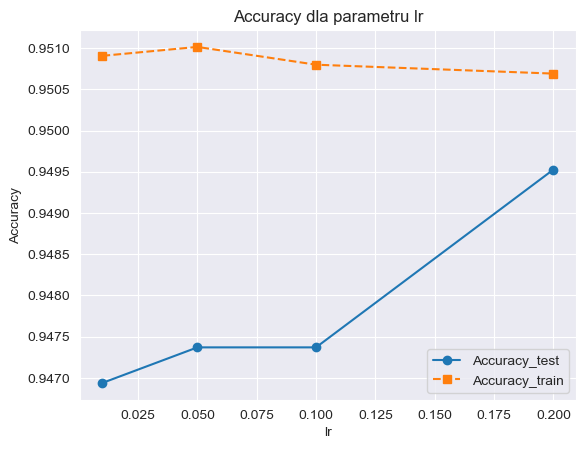

Najlepsza wartość parametru lr: 0.2 z Accuracy_test = 0.950


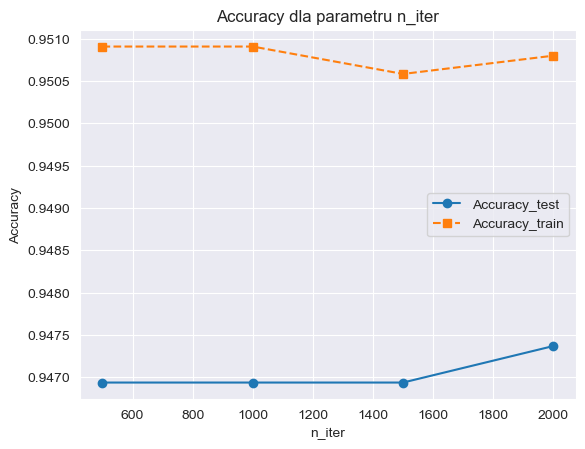

Najlepsza wartość parametru n_iter: 2000.0 z Accuracy_test = 0.947


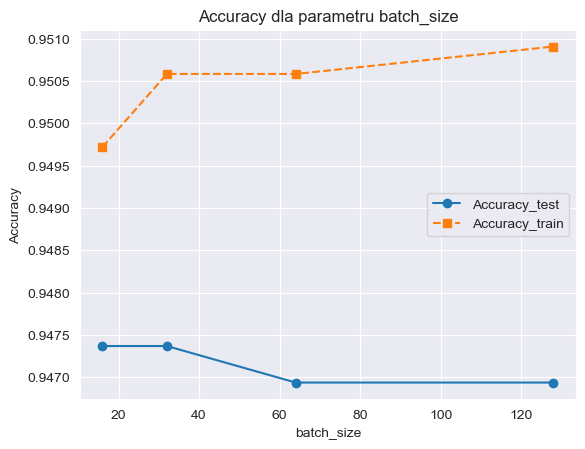

Najlepsza wartość parametru batch_size: 16.0 z Accuracy_test = 0.947


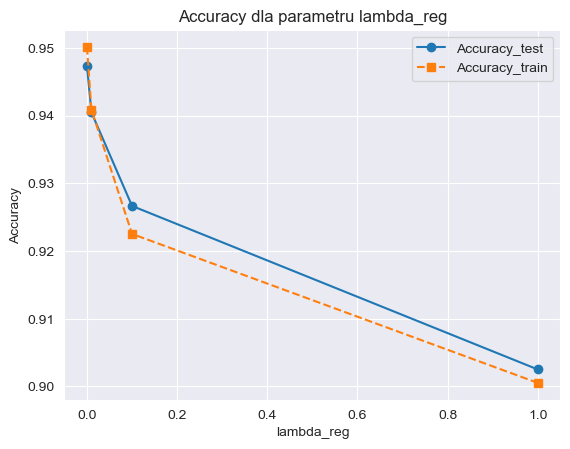

Najlepsza wartość parametru lambda_reg: 0.0 z Accuracy_test = 0.947


In [13]:
for param in wyniki_log_df['parametr'].unique():
    df = wyniki_log_df[wyniki_log_df['parametr'] == param]

    plt.figure()
    plt.plot(df['wartość'], df['Accuracy_test'], marker='o', label='Accuracy_test')
    plt.plot(df['wartość'], df['Accuracy_train'], marker='s', linestyle='--', label='Accuracy_train')
    plt.xlabel(param)
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy dla parametru {param}')
    plt.grid(True)
    plt.legend()
    plt.show()

    best_row = df.loc[df['Accuracy_test'].idxmax()]
    print(f"Najlepsza wartość parametru {param}: {best_row['wartość']} z Accuracy_test = {best_row['Accuracy_test']:.3f}")


In [14]:
classes = ['Rainy', 'Cloudy', 'Sunny', 'Snowy']

def mean_f1(df):
    cols = [f"F1_test_class_{i}" for i in range(len(classes))]
    return df[cols].mean(axis=1)

wyniki_log_df['F1_test_mean'] = mean_f1(wyniki_log_df)


best_values = wyniki_log_df.loc[wyniki_log_df.groupby('parametr')['F1_test_mean'].idxmax(), ['parametr', 'wartość', 'F1_test_mean']]
best_values.round(4).reset_index(drop=True)


,parametr,wartość,F1_test_mean
0,batch_size,32.0,0.9481
1,lambda_reg,0.0,0.9481
2,lr,0.2,0.9503
3,n_iter,2000.0,0.9481


In [15]:
def mean_precision(df):
    cols = [f"Precision_test_class_{i}" for i in range(len(classes))]
    return df[cols].mean(axis=1)

wyniki_log_df['Precision_test_mean'] = mean_precision(wyniki_log_df)

best_precision_values = wyniki_log_df.loc[wyniki_log_df.groupby('parametr')['Precision_test_mean'].idxmax(), ['parametr', 'wartość', 'Precision_test_mean']]

best_precision_values.round(4).reset_index(drop=True)


,parametr,wartość,Precision_test_mean
0,batch_size,16.0,0.9482
1,lambda_reg,0.0,0.9482
2,lr,0.2,0.9506
3,n_iter,2000.0,0.9482


In [16]:
def mean_recall(df):
    cols = [f"Recall_test_class_{i}" for i in range(len(classes))]
    return df[cols].mean(axis=1)

wyniki_log_df['Recall_test_mean'] = mean_recall(wyniki_log_df)

best_recall_values = wyniki_log_df.loc[wyniki_log_df.groupby('parametr')['Recall_test_mean'].idxmax(), ['parametr', 'wartość', 'Recall_test_mean']]

best_recall_values.round(4).reset_index(drop=True)


,parametr,wartość,Recall_test_mean
0,batch_size,16.0,0.9483
1,lambda_reg,0.0,0.9483
2,lr,0.2,0.9505
3,n_iter,2000.0,0.9483


Analiza otrzymanych wyników wykazała, że regresja logistyczna najlepiej radzi sobie z klasyfikacją pogody przy:
 - batch_size = 16.0 lub 32.0
 - lambda_reg = 0.0
 - lr = 0.2
 - n_iter = 2000.0


## Implementacja KNN 

| Parametr        | Znaczenie i sens testowania                                                                 |
|------------------|---------------------------------------------------------------------------------------------|
| `n_neighbors`    | Liczba sąsiadów branych pod uwagę przy klasyfikacji – decyduje o lokalnej lub globalnej naturze decyzji modelu. Zbyt mała wartość może prowadzić do przeuczenia, a zbyt duża – do niedouczenia. |
| `weights`        | Określa, czy głosy sąsiadów mają równą wagę (`uniform`), czy są ważone odwrotnie do odległości (`distance`). Testowanie pomaga wybrać lepszą strategię dla danych o różnej gęstości. |
| `p`              | Parametr metryki Minkowskiego – `p=1` to metryka Manhattan, `p=2` to Euklides, inne wartości pozwalają dostosować przestrzeń metryczną. Testowanie pomaga dobrać optymalną odległość dla danych. |
| `tie_breaker`    | Strategia rozstrzygania remisów (np. losowanie lub preferowanie bliższych sąsiadów). Testowanie pomaga uniknąć niejednoznaczności w przypadku równych głosów. |


In [17]:
class FastKNNClassifier:
    def __init__(self, n_neighbors=5, weights='uniform', p=2, tie_breaker='random', batch_size=1000):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.p = p
        self.tie_breaker = tie_breaker
        self.batch_size = batch_size

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _compute_distances(self, X_batch):
        diff = X_batch[:, np.newaxis, :] - self.X_train[np.newaxis, :, :]
        return np.linalg.norm(diff, ord=self.p, axis=2)

    def _get_top_k(self, distances):
        indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        top_distances = np.take_along_axis(distances, indices, axis=1)
        top_labels = self.y_train[indices]
        return top_labels, top_distances

    def _vote_batch(self, labels, dists):
        preds = []
        for lbls, dsts in zip(labels, dists):
            weights = {}
            for label, dist in zip(lbls, dsts):
                if self.weights == 'uniform':
                    w = 1
                elif self.weights == 'distance':
                    w = 1 / max(dist, 1e-3)
                elif self.weights == 'custom_linear':
                    w = max(1e-3, 1 - dist)
                elif self.weights == 'custom_inverse':
                    w = 1 / (1 + dist)
                else:
                    raise ValueError("Nieznana metoda wagowania")
                weights[label] = weights.get(label, 0) + w
            max_w = max(weights.values())
            top_labels = [lbl for lbl, w in weights.items() if w == max_w]
            preds.append(self._break_ties(top_labels))
        return np.array(preds)

    def _break_ties(self, labels):
        if self.tie_breaker == 'random':
            return random.choice(labels)
        elif self.tie_breaker == 'first':
            return labels[0]
        elif self.tie_breaker == 'min_label':
            return min(labels)
        elif self.tie_breaker == 'max_label':
            return max(labels)
        else:
            raise ValueError("Nieznany tie_breaker")

    def predict(self, X):
        preds = []
        for i in range(0, len(X), self.batch_size):
            X_batch = X[i:i + self.batch_size]
            distances = self._compute_distances(X_batch)
            if X.shape[0] == self.X_train.shape[0] and np.allclose(X, self.X_train):
                np.fill_diagonal(distances, np.inf)
            labels, dists = self._get_top_k(distances)
            preds.extend(self._vote_batch(labels, dists))
        return np.array(preds)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_recall_f1(y_true, y_pred):
    classes = np.unique(y_true)
    precision, recall, f1 = [], [], []
    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))
        prec = tp / (tp + fp) if tp + fp > 0 else 0
        rec  = tp / (tp + fn) if tp + fn > 0 else 0
        f1s  = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0
        precision.append(prec)
        recall.append(rec)
        f1.append(f1s)
    return np.array(precision), np.array(recall), np.array(f1)

## Analiza KNN

In [18]:
wyniki_knn_df = pd.read_csv('klasyfikacja/wyniki_knn_classification.csv')
wyniki_knn_df.head()


,parametr,wartość,accuracy_train_avg,accuracy_test_avg,precision_train_class_0,recall_train_class_0,f1_train_class_0,precision_test_class_0,recall_test_class_0,f1_test_class_0,...,f1_train_class_2,precision_test_class_2,recall_test_class_2,f1_test_class_2,precision_train_class_3,recall_train_class_3,f1_train_class_3,precision_test_class_3,recall_test_class_3,f1_test_class_3
0,weights,uniform,0.969150,0.9577,0.955896,0.953393,0.954640,0.934102,0.940379,0.937181,...,0.987383,0.975752,0.982452,0.979075,0.984849,0.967766,0.976232,0.982909,0.960070,0.971340
1,weights,distance,0.994475,0.9587,0.991824,0.991526,0.991673,0.936454,0.942384,0.939337,...,0.998133,0.975267,0.982452,0.978832,0.997626,0.994377,0.995999,0.982239,0.961613,0.971798
2,weights,custom_linear,0.994400,0.9581,0.991526,0.991330,0.991427,0.933563,0.938810,0.936108,...,0.998183,0.980115,0.982452,0.981270,0.997921,0.994477,0.996196,0.980201,0.960468,0.970199
3,weights,custom_inverse,0.983500,0.9585,0.976458,0.976744,0.976598,0.935415,0.942766,0.939005,...,0.992278,0.975267,0.982452,0.978832,0.992138,0.982547,0.987318,0.982597,0.960842,0.971582
4,p,1,0.970600,0.9613,0.962860,0.953691,0.958251,0.949981,0.939946,0.944883,...,0.987433,0.976046,0.983296,0.979642,0.985771,0.969541,0.977586,0.980417,0.964333,0.972281


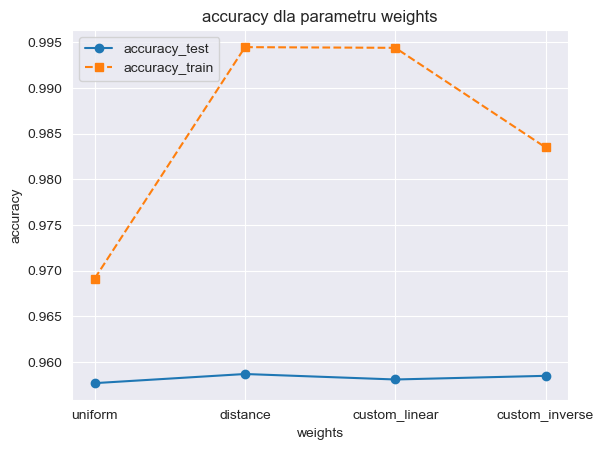

Najlepsza wartość parametru weights: distance z accuracy_test = 0.959


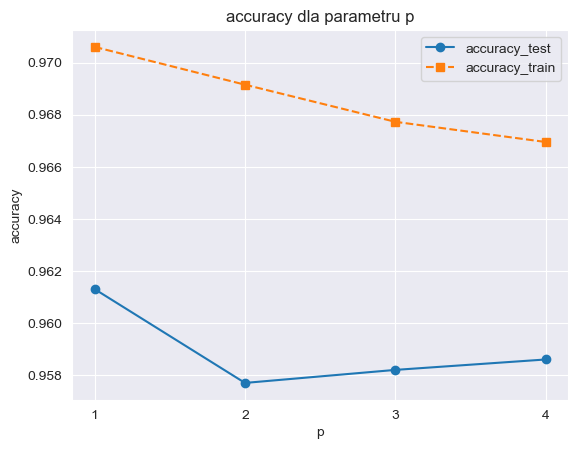

Najlepsza wartość parametru p: 1 z accuracy_test = 0.961


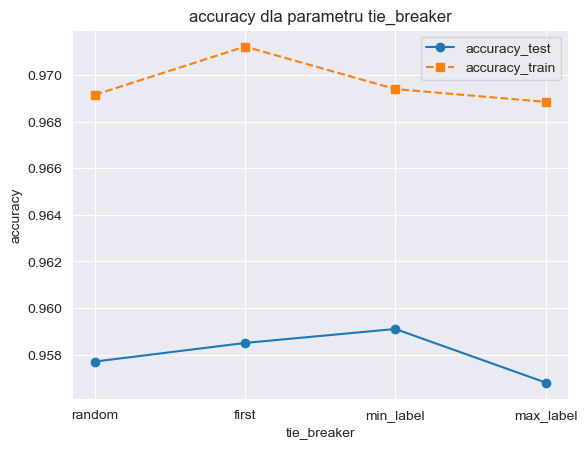

Najlepsza wartość parametru tie_breaker: min_label z accuracy_test = 0.959


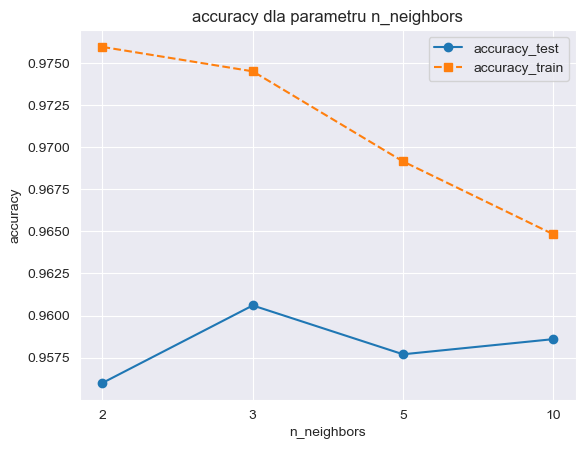

Najlepsza wartość parametru n_neighbors: 3 z accuracy_test = 0.961


In [19]:
for param in wyniki_knn_df['parametr'].unique():
    df = wyniki_knn_df[wyniki_knn_df['parametr'] == param]

    plt.figure()
    plt.plot(df['wartość'], df['accuracy_test_avg'], marker='o', label='accuracy_test')
    plt.plot(df['wartość'], df['accuracy_train_avg'], marker='s', linestyle='--', label='accuracy_train')
    plt.xlabel(param)
    plt.ylabel('accuracy')
    plt.title(f'accuracy dla parametru {param}')
    plt.grid(True)
    plt.legend()
    plt.show()

    best_row = df.loc[df['accuracy_test_avg'].idxmax()]
    print(f"Najlepsza wartość parametru {param}: {best_row['wartość']} z accuracy_test = {best_row['accuracy_test_avg']:.3f}")

In [20]:
classes = ['Rainy', 'Cloudy', 'Sunny', 'Snowy']

def mean_f1(df):
    cols = [f"f1_test_class_{i}" for i in range(len(classes))]
    return df[cols].mean(axis=1)

wyniki_knn_df['f1_test_mean'] = mean_f1(wyniki_knn_df)


best_values = wyniki_knn_df.loc[wyniki_knn_df.groupby('parametr')['f1_test_mean'].idxmax(), ['parametr', 'wartość', 'f1_test_mean']]
best_values.round(4).reset_index(drop=True)

,parametr,wartość,f1_test_mean
0,n_neighbors,3,0.9606
1,p,1,0.9613
2,tie_breaker,min_label,0.9592
3,weights,distance,0.9588


In [21]:
def mean_precision(df):
    cols = [f"precision_test_class_{i}" for i in range(len(classes))]
    return df[cols].mean(axis=1)

wyniki_knn_df['precision_test_mean'] = mean_precision(wyniki_knn_df)

best_precision_values = wyniki_knn_df.loc[wyniki_knn_df.groupby('parametr')['precision_test_mean'].idxmax(), ['parametr', 'wartość', 'precision_test_mean']]

best_precision_values.round(4).reset_index(drop=True)


,parametr,wartość,precision_test_mean
0,n_neighbors,3,0.9606
1,p,1,0.9613
2,tie_breaker,min_label,0.9593
3,weights,distance,0.9588


In [22]:
def mean_recall(df):
    cols = [f"recall_test_class_{i}" for i in range(len(classes))]
    return df[cols].mean(axis=1)


wyniki_knn_df['recall_test_mean'] = mean_recall(wyniki_knn_df)

best_recall_values = wyniki_knn_df.loc[
    wyniki_knn_df.groupby('parametr')['recall_test_mean'].idxmax(), ['parametr', 'wartość', 'recall_test_mean']]

best_recall_values.round(4).reset_index(drop=True)

,parametr,wartość,recall_test_mean
0,n_neighbors,3,0.9608
1,p,1,0.9615
2,tie_breaker,min_label,0.9593
3,weights,distance,0.9589


Wnioski:
- Dokładność na zbiorze testowym pozostaje stabilna (~0.958) niezależnie od wybranego typu wag, co wskazuje, że zmiana funkcji wag nie wpływa znacząco na ogólną skuteczność modelu.
- Największa rozbieżność między accuracy_train a accuracy_test występuje dla wag distance i custom_linear, co również może świadczyć o nadmiernym dopasowaniu do danych treningowych.
- Najlepsze wyniki testowe (accuracy_test) uzyskano dla p = 1, co oznacza, że metryka Manhattan (L1) działa lepiej niż standardowa Euklidesowa (L2) w tym przypadku.
- Brak dużych różnic między wynikami wskazuje na relatywną stabilność modelu względem zmiany parametru p, jednak p = 1 wydaje się być najoptymalniejszym wyborem.
- Największą dokładność na zbiorze treningowym osiągnięto przy first, co jednak nie przełożyło się na najlepszy wynik testowy, co może oznaczać lekką tendencję do przeuczenia.
- Różnice w accuracy pomiędzy ustawieniami tie_breaker są niewielkie, co oznacza, że parametr ten ma ograniczony wpływ na końcową skuteczność modelu, ale mimo wszystko min_label wydaje się najbardziej korzystny.
- Wraz ze wzrostem wartości n_neighbors dokładność modelu stopniowo spada, osiągając minimum (~0.9575) dla n_neighbors=10.

# Podsumowanie projektu klasyfikacji pogody

## Założenia i wyniki

W ramach projektu zaimplementowano i porównano trzy różne algorytmy klasyfikacji pogody: drzewo decyzyjne, regresję logistyczną oraz algorytm k-najbliższych sąsiadów (KNN).

Dane wejściowe zostały odpowiednio przetworzone poprzez kodowanie zmiennych kategorycznych i usuwanie wartości odstających metodą IQR.

Najlepsze wyniki osiągnęło drzewo decyzyjne z parametrami max_depth=8 i min_samples_split=100, osiągając wysoką dokładność klasyfikacji.

Regresja logistyczna wykazała najlepszą skuteczność przy learning_rate=0.2 i 2000 iteracjach, co pozwoliło na stabilne uczenie modelu.

W przypadku algorytmu KNN, najlepsze rezultaty uzyskano stosując metrykę Manhattan oraz strategię min_label dla rozwiązywania remisów.

Każdy z zaimplementowanych modeli przeszedł szczegółową analizę parametrów i został zoptymalizowany pod kątem dokładności klasyfikacji.

Wszystkie trzy modele osiągnęły dokładność na poziomie około 95-96%, co świadczy o ich wysokiej skuteczności w zadaniu klasyfikacji warunków pogodowych.

Do oceny skuteczności modeli wykorzystano różne metryki, takie jak accuracy, precision, recall oraz F1-score, które potwierdziły wysoką jakość klasyfikacji.